# Resource Configuration Analysis

This notebook analyzes resource configurations across all resource types to identify common patterns.

**Goals:**
1. Understand what properties are common across resource types
2. Identify natural grouping patterns (location, resource group, tags)
3. Determine if metadata-based selection makes sense or if simpler approaches are better

**Approach:**
- Query Neo4j for all resources and their configurations
- Analyze property patterns across resource types
- Look for co-occurrence patterns (what resources appear together)
- Visualize the findings

## Setup

In [1]:
import os
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import pandas as pd
from neo4j import GraphDatabase

# Configure plotting
plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline

# Neo4j connection
NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.getenv("NEO4J_USER", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "neo4j123")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

print("✅ Setup complete")
print(f"   Neo4j URI: {NEO4J_URI}")

✅ Setup complete
   Neo4j URI: bolt://localhost:7687


## 1. Overview: Resource Types and Counts

In [2]:
with driver.session() as session:
    result = session.run("""
        MATCH (r:Resource:Original)
        RETURN r.type as resource_type, count(*) as count
        ORDER BY count DESC
    """)

    resource_types = []
    for record in result:
        resource_types.append(
            {"type": record["resource_type"], "count": record["count"]}
        )

df_types = pd.DataFrame(resource_types)

print(f"Total resource types: {len(df_types)}")
print(f"Total resources: {df_types['count'].sum()}")
print("\nTop 20 most common resource types:")
print(df_types.head(20).to_string(index=False))

Total resource types: 94
Total resources: 3459

Top 20 most common resource types:
                                                 type  count
              Microsoft.Authorization/roleAssignments   1042
                  Microsoft.Network/networkInterfaces    214
              Microsoft.Network/networkSecurityGroups    207
                            Microsoft.Network/subnets    202
                  Microsoft.Network/publicIPAddresses    138
                              Microsoft.Compute/disks    125
         Microsoft.Compute/virtualMachines/extensions    118
                    Microsoft.Compute/virtualMachines    114
     Microsoft.ManagedIdentity/userAssignedIdentities    113
                    Microsoft.Network/virtualNetworks    107
                    Microsoft.Storage/storageAccounts     92
                            Microsoft.KeyVault/vaults     83
                   Microsoft.Network/privateEndpoints     74
                    Microsoft.Network/privateDnsZones     66
Mi

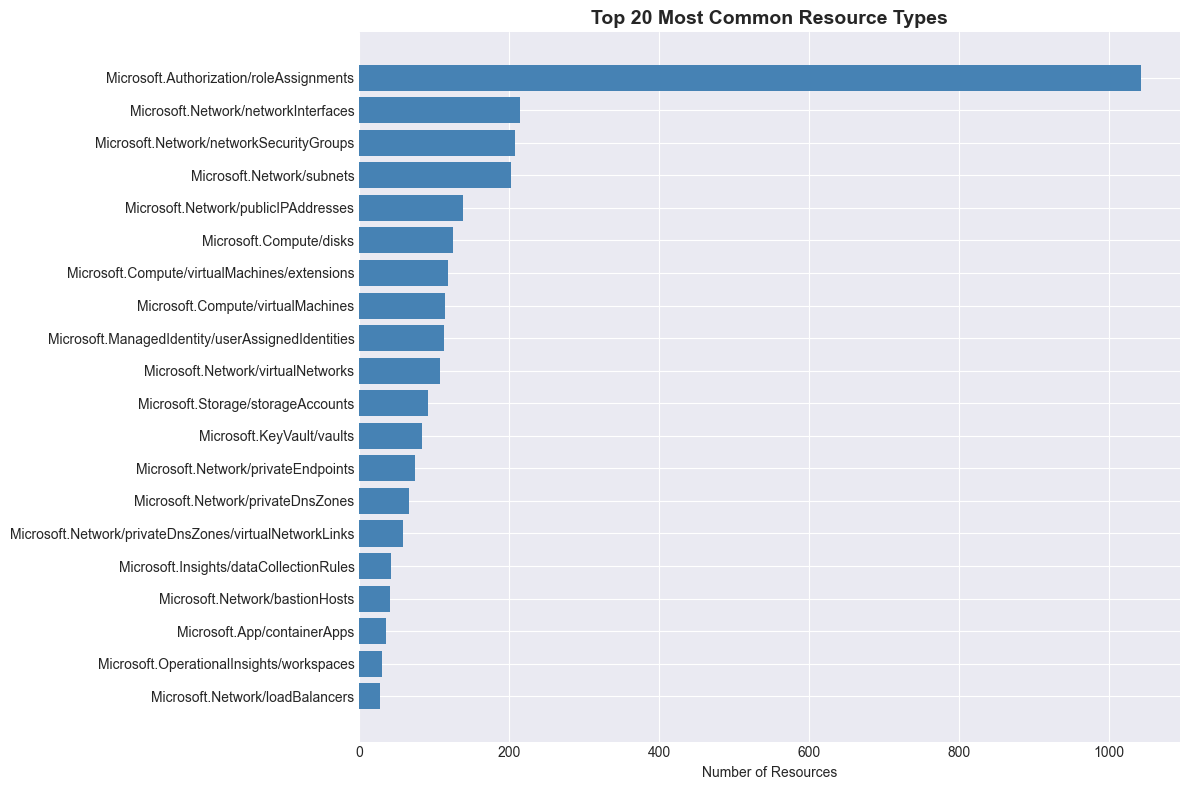

In [3]:
# Visualize top resource types
fig, ax = plt.subplots(figsize=(12, 8))

top_20 = df_types.head(20)
ax.barh(range(len(top_20)), top_20["count"], color="steelblue")
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20["type"])
ax.set_xlabel("Number of Resources")
ax.set_title("Top 20 Most Common Resource Types", fontsize=14, fontweight="bold")
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 2. Common Properties Across Resource Types

What properties appear in most/all resource types?

In [4]:
with driver.session() as session:
    # Get sample resources from top resource types
    top_types = df_types.head(20)["type"].tolist()

    property_across_types = defaultdict(set)

    for resource_type in top_types:
        result = session.run(
            """
            MATCH (r:Resource:Original)
            WHERE r.type = $resource_type
            RETURN r LIMIT 10
        """,
            resource_type=resource_type,
        )

        for record in result:
            resource = record["r"]
            properties = dict(resource.items())

            for prop_name in properties.keys():
                if prop_name not in ["id", "type", "updated_at"]:
                    property_across_types[prop_name].add(resource_type)

# Create dataframe of common properties
common_props = []
for prop, types in property_across_types.items():
    common_props.append(
        {
            "property": prop,
            "appears_in_types": len(types),
            "percentage": len(types) / len(top_types) * 100,
        }
    )

df_common_props = pd.DataFrame(common_props).sort_values(
    "appears_in_types", ascending=False
)

print("Properties that appear in multiple resource types:")
print(df_common_props.head(15).to_string(index=False))

Properties that appear in multiple resource types:
         property  appears_in_types  percentage
  subscription_id                20       100.0
    abstracted_id                20       100.0
  llm_description                20       100.0
             name                20       100.0
processing_status                20       100.0
       properties                20       100.0
   resource_group                20       100.0
             __id                19        95.0
        __attempt                19        95.0
         location                19        95.0
             tags                 6        30.0
        parent_id                 1         5.0
     addressSpace                 1         5.0


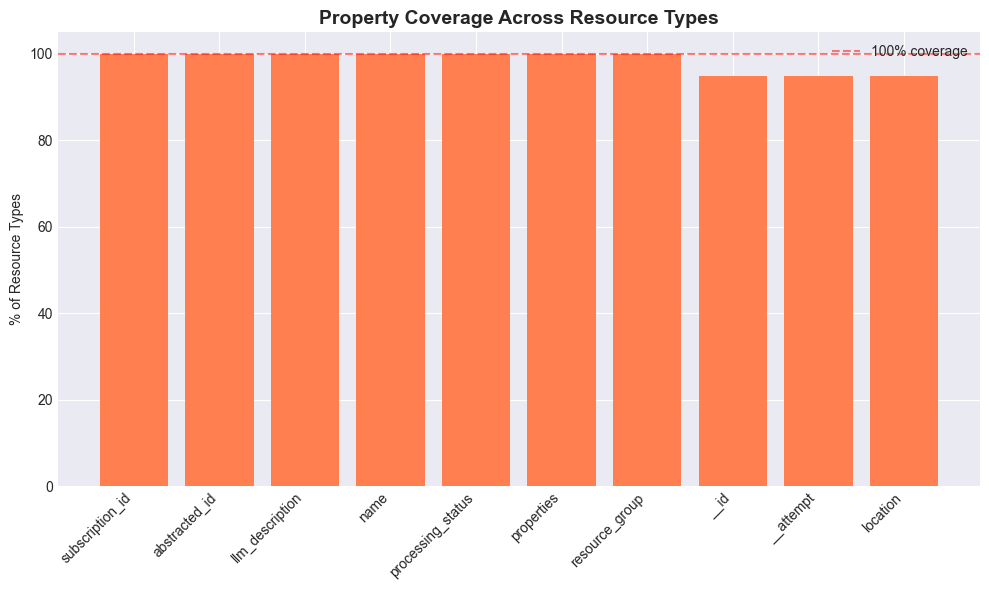

In [5]:
# Visualize property coverage
fig, ax = plt.subplots(figsize=(10, 6))

top_props = df_common_props.head(10)
ax.bar(range(len(top_props)), top_props["percentage"], color="coral")
ax.set_xticks(range(len(top_props)))
ax.set_xticklabels(top_props["property"], rotation=45, ha="right")
ax.set_ylabel("% of Resource Types")
ax.set_title("Property Coverage Across Resource Types", fontsize=14, fontweight="bold")
ax.axhline(y=100, color="red", linestyle="--", alpha=0.5, label="100% coverage")
ax.legend()

plt.tight_layout()
plt.show()

## 3. Location Analysis

Azure regions are a fundamental grouping mechanism.

In [6]:
with driver.session() as session:
    result = session.run("""
        MATCH (r:Resource:Original)
        WHERE r.location IS NOT NULL
        RETURN r.location as location, count(*) as count
        ORDER BY count DESC
    """)

    locations = []
    for record in result:
        locations.append({"location": record["location"], "count": record["count"]})

df_locations = pd.DataFrame(locations)
df_locations["percentage"] = df_locations["count"] / df_locations["count"].sum() * 100

print("Location Distribution:")
print(df_locations.head(15).to_string(index=False))
print(
    f"\nTop 3 locations account for {df_locations.head(3)['percentage'].sum():.1f}% of resources"
)

Location Distribution:
        location  count  percentage
         westus2    705   29.168391
       centralus    508   21.017791
          eastus    257   10.633016
         westus3    235    9.722797
          global    204    8.440215
  northcentralus    172    7.116260
          westus    162    6.702524
         eastus2    129    5.337195
  southcentralus     26    1.075714
   swedencentral      7    0.289615
   westcentralus      6    0.248242
   australiaeast      2    0.082747
switzerlandnorth      1    0.041374
          ukwest      1    0.041374
         uksouth      1    0.041374

Top 3 locations account for 60.8% of resources


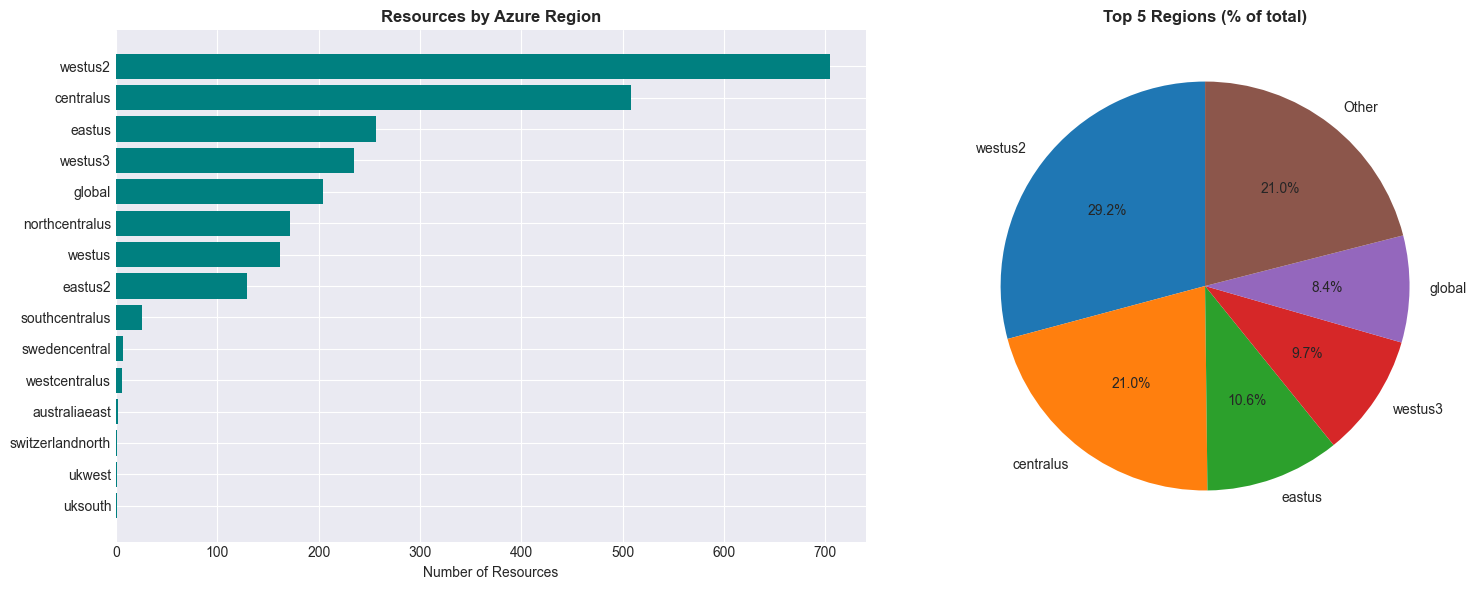

In [7]:
# Visualize location distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
top_15_loc = df_locations.head(15)
ax1.barh(range(len(top_15_loc)), top_15_loc["count"], color="teal")
ax1.set_yticks(range(len(top_15_loc)))
ax1.set_yticklabels(top_15_loc["location"])
ax1.set_xlabel("Number of Resources")
ax1.set_title("Resources by Azure Region", fontsize=12, fontweight="bold")
ax1.invert_yaxis()

# Pie chart for top 5
top_5_loc = df_locations.head(5)
other_count = df_locations.iloc[5:]["count"].sum()
pie_data = list(top_5_loc["count"]) + [other_count]
pie_labels = list(top_5_loc["location"]) + ["Other"]

ax2.pie(pie_data, labels=pie_labels, autopct="%1.1f%%", startangle=90)
ax2.set_title("Top 5 Regions (% of total)", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

## 4. Resource Group Analysis

Resource groups are Azure's primary organizational unit - the natural architectural boundary.

In [8]:
with driver.session() as session:
    result = session.run("""
        MATCH (r:Resource:Original)
        WHERE r.resource_group IS NOT NULL
        WITH r.resource_group as rg, 
             r.location as location,
             count(r) as resource_count,
             collect(DISTINCT r.type) as resource_types
        WHERE resource_count > 1
        RETURN rg, location, resource_count, size(resource_types) as unique_types, resource_types
        ORDER BY resource_count DESC
        LIMIT 30
    """)

    resource_groups = []
    for record in result:
        resource_groups.append(
            {
                "resource_group": record["rg"],
                "location": record["location"],
                "resource_count": record["resource_count"],
                "unique_types": record["unique_types"],
                "resource_types": record["resource_types"],
            }
        )

df_rgs = pd.DataFrame(resource_groups)

print("Top 30 Resource Groups by Resource Count:")
print(
    df_rgs[["resource_group", "location", "resource_count", "unique_types"]].to_string(
        index=False
    )
)

Top 30 Resource Groups by Resource Count:
         resource_group       location  resource_count  unique_types
               SimuLand        westus2             136            15
  rysweet-linux-vm-pool        westus2              85             9
            rg-adapt-ai           None              74             1
  rysweet-linux-vm-pool        westus3              61             8
   TheContinentalHotels         eastus              52            17
                 MAIDAP        westus2              39            11
                 MAIDAP      centralus              38             7
       sparta_attackbot        westus2              38            11
ARTBAS-150824j9aejyqncm northcentralus              37            13
ARTBAS-090824g961kjf0od northcentralus              37            13
ARTBAS-190724pleef40zad northcentralus              37            13
      ai-soc-analyst-rg           None              36             1
            arjunc-test        westus2              36       

In [9]:
# Show detailed composition of top resource groups
print("Detailed Composition of Top 10 Resource Groups:\n")

for idx, row in df_rgs.head(10).iterrows():
    print(f"{idx + 1}. {row['resource_group']} ({row['location']})")
    print(
        f"   Total: {row['resource_count']} resources across {row['unique_types']} types"
    )
    print(f"   Types: {', '.join(row['resource_types'][:5])}")
    if len(row["resource_types"]) > 5:
        print(f"          ... and {len(row['resource_types']) - 5} more")
    print()

Detailed Composition of Top 10 Resource Groups:

1. SimuLand (westus2)
   Total: 136 resources across 15 types
   Types: Microsoft.Network/virtualNetworks, Microsoft.Network/subnets, Microsoft.Network/networkSecurityGroups, Microsoft.Compute/virtualMachines, Microsoft.Network/networkInterfaces
          ... and 10 more

2. rysweet-linux-vm-pool (westus2)
   Total: 85 resources across 9 types
   Types: Microsoft.Network/networkSecurityGroups, Microsoft.Network/publicIPAddresses, Microsoft.Network/virtualNetworks, Microsoft.Network/subnets, Microsoft.Network/bastionHosts
          ... and 4 more

3. rg-adapt-ai (None)
   Total: 74 resources across 1 types
   Types: Microsoft.Authorization/roleAssignments

4. rysweet-linux-vm-pool (westus3)
   Total: 61 resources across 8 types
   Types: Microsoft.Network/virtualNetworks, Microsoft.Network/subnets, Microsoft.Network/publicIPAddresses, Microsoft.Network/bastionHosts, Microsoft.Network/networkSecurityGroups
          ... and 3 more

5. TheC

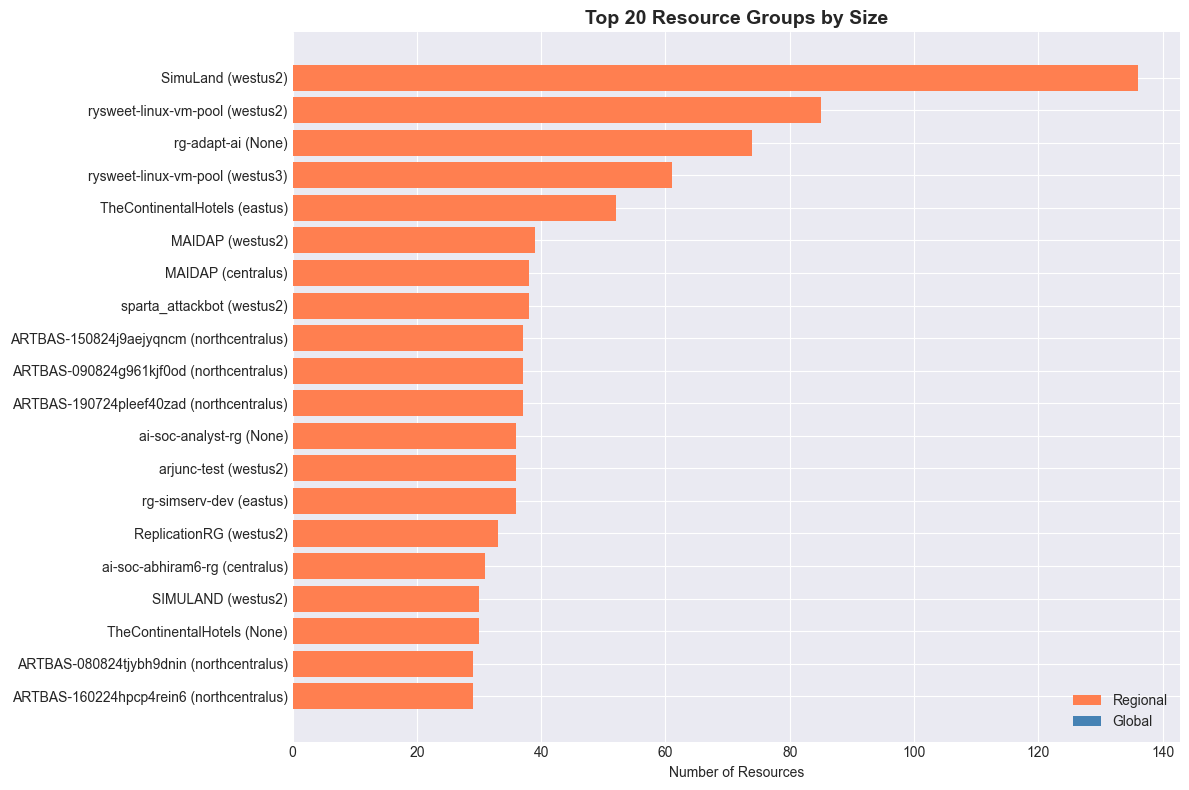

In [10]:
# Visualize resource group sizes
fig, ax = plt.subplots(figsize=(12, 8))

top_20_rg = df_rgs.head(20)
colors = ["steelblue" if loc == "global" else "coral" for loc in top_20_rg["location"]]

ax.barh(range(len(top_20_rg)), top_20_rg["resource_count"], color=colors)
ax.set_yticks(range(len(top_20_rg)))
ax.set_yticklabels(
    [
        f"{rg} ({loc})"
        for rg, loc in zip(top_20_rg["resource_group"], top_20_rg["location"])
    ]
)
ax.set_xlabel("Number of Resources")
ax.set_title("Top 20 Resource Groups by Size", fontsize=14, fontweight="bold")
ax.invert_yaxis()

# Add legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="coral", label="Regional"),
    Patch(facecolor="steelblue", label="Global"),
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

## 5. Tags Analysis

Are tags widely used? What patterns exist?

In [11]:
with driver.session() as session:
    # Count resources with tags
    result = session.run("""
        MATCH (r:Resource:Original)
        RETURN 
            count(r) as total,
            count(CASE WHEN r.tags IS NOT NULL THEN 1 END) as with_tags
    """)

    record = result.single()
    total = record["total"]
    with_tags = record["with_tags"]

    print("Tags Usage:")
    print(f"  Total resources: {total}")
    print(f"  Resources with tags: {with_tags} ({with_tags / total * 100:.1f}%)")
    print(
        f"  Resources without tags: {total - with_tags} ({(total - with_tags) / total * 100:.1f}%)"
    )

    # Analyze tag keys
    result = session.run("""
        MATCH (r:Resource:Original)
        WHERE r.tags IS NOT NULL
        RETURN r.type as resource_type, r.tags as tags
        LIMIT 200
    """)

    tag_keys = Counter()
    tag_by_type = defaultdict(Counter)

    for record in result:
        resource_type = record["resource_type"]
        tags = record["tags"]

        if isinstance(tags, dict):
            for key in tags.keys():
                tag_keys[key] += 1
                tag_by_type[resource_type][key] += 1

    if tag_keys:
        print("\nMost Common Tag Keys:")
        for key, count in tag_keys.most_common(15):
            print(f"  {key:50s} : {count} resources")
    else:
        print("\n⚠️  No tags found in sample")

Tags Usage:
  Total resources: 3459
  Resources with tags: 314 (9.1%)
  Resources without tags: 3145 (90.9%)

⚠️  No tags found in sample


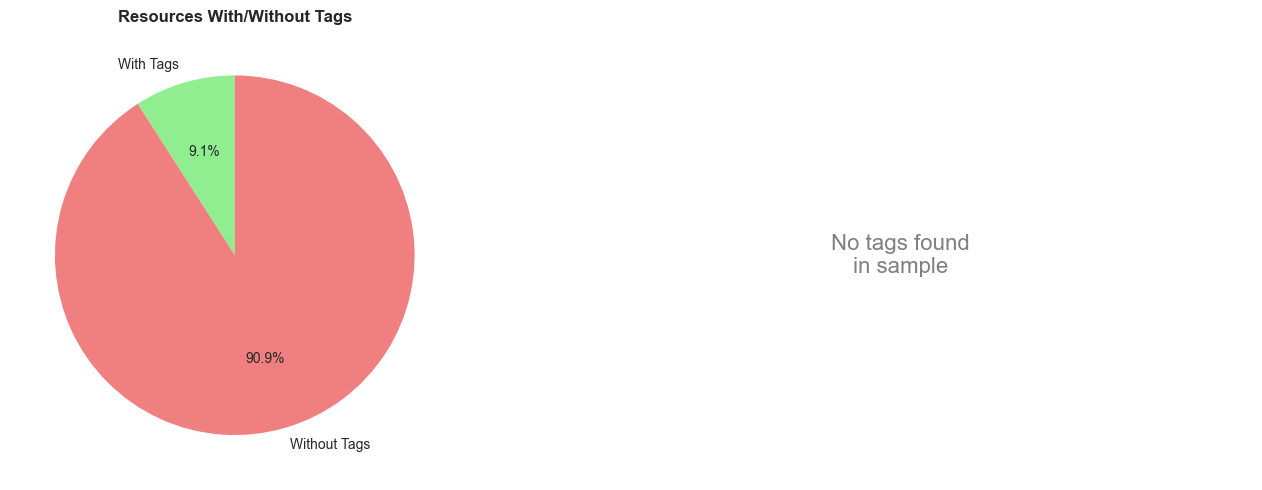

In [12]:
# Visualize tag usage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of tag usage
ax1.pie(
    [with_tags, total - with_tags],
    labels=["With Tags", "Without Tags"],
    autopct="%1.1f%%",
    colors=["lightgreen", "lightcoral"],
    startangle=90,
)
ax1.set_title("Resources With/Without Tags", fontsize=12, fontweight="bold")

# Bar chart of tag keys (if any)
if tag_keys:
    top_tags = dict(tag_keys.most_common(10))
    ax2.barh(list(top_tags.keys()), list(top_tags.values()), color="mediumpurple")
    ax2.set_xlabel("Number of Resources")
    ax2.set_title("Most Common Tag Keys", fontsize=12, fontweight="bold")
    ax2.invert_yaxis()
else:
    ax2.text(
        0.5,
        0.5,
        "No tags found\nin sample",
        ha="center",
        va="center",
        fontsize=16,
        color="gray",
    )
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis("off")

plt.tight_layout()
plt.show()

## 6. Co-occurrence Patterns

What resources naturally appear together?

In [13]:
with driver.session() as session:
    # Find resource types that frequently co-occur in the same resource group
    result = session.run("""
        MATCH (r:Resource:Original)
        WHERE r.resource_group IS NOT NULL
        WITH r.resource_group as rg, collect(DISTINCT r.type) as types
        WHERE size(types) >= 3
        UNWIND types as type
        RETURN type, count(*) as frequency
        ORDER BY frequency DESC
        LIMIT 15
    """)

    print("Resource Types Most Frequently in Multi-Resource Groups:")
    cooccurrence = []
    for record in result:
        cooccurrence.append({"type": record["type"], "frequency": record["frequency"]})
        print(f"  {record['type']:60s} : {record['frequency']} groups")

df_cooccur = pd.DataFrame(cooccurrence)

Resource Types Most Frequently in Multi-Resource Groups:
  Microsoft.Authorization/roleAssignments                      : 97 groups
  Microsoft.Network/virtualNetworks                            : 67 groups
  Microsoft.Network/subnets                                    : 67 groups
  Microsoft.KeyVault/vaults                                    : 62 groups
  Microsoft.Network/networkSecurityGroups                      : 62 groups
  Microsoft.Network/publicIPAddresses                          : 61 groups
  Microsoft.ManagedIdentity/userAssignedIdentities             : 59 groups
  Microsoft.Network/networkInterfaces                          : 58 groups
  Microsoft.Storage/storageAccounts                            : 42 groups
  Microsoft.Compute/virtualMachines                            : 41 groups
  Microsoft.Network/loadBalancers                              : 26 groups
  microsoft.alertsmanagement/smartDetectorAlertRules           : 25 groups
  Microsoft.OperationalInsights/workspaces 

In [14]:
# Find common resource type pairs
with driver.session() as session:
    result = session.run("""
        MATCH (r1:Resource:Original), (r2:Resource:Original)
        WHERE r1.resource_group = r2.resource_group
          AND r1.resource_group IS NOT NULL
          AND r1.type < r2.type
        WITH r1.type as type1, r2.type as type2, count(*) as pair_count
        WHERE pair_count >= 5
        RETURN type1, type2, pair_count
        ORDER BY pair_count DESC
        LIMIT 20
    """)

    print("\nMost Common Resource Type Pairs (same resource group):")
    for record in result:
        print(f"  {record['type1']}")
        print(f"    + {record['type2']}")
        print(f"    → {record['pair_count']} resource groups\n")


Most Common Resource Type Pairs (same resource group):
  Microsoft.Network/networkSecurityGroups
    + Microsoft.Network/publicIPAddresses
    → 3981 resource groups

  Microsoft.Network/networkInterfaces
    + Microsoft.Network/networkSecurityGroups
    → 2502 resource groups

  Microsoft.Authorization/roleAssignments
    + Microsoft.Network/subnets
    → 1827 resource groups

  Microsoft.Authorization/roleAssignments
    + Microsoft.Network/networkInterfaces
    → 1500 resource groups

  Microsoft.Network/networkSecurityGroups
    + Microsoft.Network/subnets
    → 1496 resource groups

  Microsoft.Compute/virtualMachines
    + Microsoft.Network/networkSecurityGroups
    → 1390 resource groups

  Microsoft.Authorization/roleAssignments
    + Microsoft.Compute/virtualMachines/extensions
    → 1352 resource groups

  Microsoft.Compute/virtualMachines/extensions
    + Microsoft.Network/networkInterfaces
    → 1243 resource groups

  Microsoft.Network/networkInterfaces
    + Microsoft.Ne

## 7. Summary & Recommendations

Based on the analysis above, let's summarize the key findings.

In [15]:
print("=" * 80)
print("CONFIGURATION ANALYSIS SUMMARY")
print("=" * 80)

print("\n1. UNIVERSAL PROPERTIES (Present in all/most resources):")
universal = df_common_props[df_common_props["percentage"] >= 90]
for _, row in universal.iterrows():
    print(f"   ✓ {row['property']:30s} ({row['percentage']:.0f}% coverage)")

print("\n2. LOCATION CLUSTERING:")
top_3_locations = df_locations.head(3)
total_in_top_3 = top_3_locations["count"].sum()
pct_in_top_3 = total_in_top_3 / df_locations["count"].sum() * 100
print(f"   • {len(df_locations)} unique locations")
print(f"   • Top 3 locations contain {pct_in_top_3:.1f}% of all resources")
for _, row in top_3_locations.iterrows():
    print(
        f"     - {row['location']:20s} : {row['count']:4d} resources ({row['percentage']:.1f}%)"
    )

print("\n3. RESOURCE GROUP PATTERNS:")
avg_resources_per_rg = df_rgs["resource_count"].mean()
avg_types_per_rg = df_rgs["unique_types"].mean()
print(f"   • Average resources per group: {avg_resources_per_rg:.1f}")
print(f"   • Average resource types per group: {avg_types_per_rg:.1f}")
print("   • Resource groups are natural architectural boundaries")

print("\n4. TAGS USAGE:")
tag_percentage = with_tags / total * 100
print(f"   • Only {tag_percentage:.1f}% of resources have tags")
if tag_percentage < 10:
    print("   ⚠️  Tags are too sparse to be reliable for grouping")
elif tag_percentage < 50:
    print("   ⚠️  Tag coverage is limited - use with caution")
else:
    print("   ✓ Tags are well-used and could be useful for grouping")

print("\n5. CO-OCCURRENCE PATTERNS:")
print("   • Resource types naturally cluster by resource_group")
print("   • Common patterns exist (see pairs analysis above)")
print("   • Location is a strong secondary grouping factor")

print("\n" + "=" * 80)
print("RECOMMENDATIONS")
print("=" * 80)

print("\nFor instance selection in architecture-based replication:")
print("\n✓ RECOMMENDED APPROACH (Simple & Fast):")
print("  1. Use resource_group as primary instance boundary")
print("  2. Group resources within same resource_group + location")
print("  3. Select instances that maximize new resource type coverage")
print("  4. Prefer instances from common locations (westus2, centralus, eastus)")

if tag_percentage < 10:
    print("\n✗ NOT RECOMMENDED:")
    print("  • Tag-based similarity (too sparse in this tenant)")
    print("  • Complex metadata queries (adds latency with little value)")
else:
    print("\n? OPTIONAL:")
    print("  • Tag-based similarity (moderate coverage, may add value)")

print("\n" + "=" * 80)

CONFIGURATION ANALYSIS SUMMARY

1. UNIVERSAL PROPERTIES (Present in all/most resources):
   ✓ subscription_id                (100% coverage)
   ✓ abstracted_id                  (100% coverage)
   ✓ llm_description                (100% coverage)
   ✓ name                           (100% coverage)
   ✓ processing_status              (100% coverage)
   ✓ properties                     (100% coverage)
   ✓ resource_group                 (100% coverage)
   ✓ __id                           (95% coverage)
   ✓ __attempt                      (95% coverage)
   ✓ location                       (95% coverage)

2. LOCATION CLUSTERING:
   • 16 unique locations
   • Top 3 locations contain 60.8% of all resources
     - westus2              :  705 resources (29.2%)
     - centralus            :  508 resources (21.0%)
     - eastus               :  257 resources (10.6%)

3. RESOURCE GROUP PATTERNS:
   • Average resources per group: 40.0
   • Average resource types per group: 11.3
   • Resource groups 

## Cleanup

In [16]:
driver.close()
print("✅ Neo4j connection closed")

✅ Neo4j connection closed
